# Analyze Order Book Data

## Imports & Settings

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from collections import Counter
from time import time
from datetime import datetime, timedelta, time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show, output_file, output_notebook
from scipy.stats import normaltest

In [2]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('fivethirtyeight')

In [4]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'AAPL'
date = '20190327'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

## Load system event data

In [6]:
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code').drop_duplicates()
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

## Trade Summary

We will combine the messages that refer to actual trades to learn about the volumes for each asset.

In [7]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8712 entries, 0 to 8711
Data columns (total 17 columns):
stock_locate                      8712 non-null int64
tracking_number                   8712 non-null int64
timestamp                         8712 non-null timedelta64[ns]
stock                             8712 non-null object
market_category                   8712 non-null object
financial_status_indicator        8712 non-null object
round_lot_size                    8712 non-null int64
round_lots_only                   8712 non-null object
issue_classification              8712 non-null object
issue_sub_type                    8712 non-null object
authenticity                      8712 non-null object
short_sale_threshold_indicator    8712 non-null object
ipo_flag                          8712 non-null object
luld_reference_price_tier         8712 non-null object
etp_flag                          8712 non-null object
etp_leverage_factor               8712 non-null int64
inverse_

As expected, a small number of the over 8,500 equity securities traded on this day account for most trades

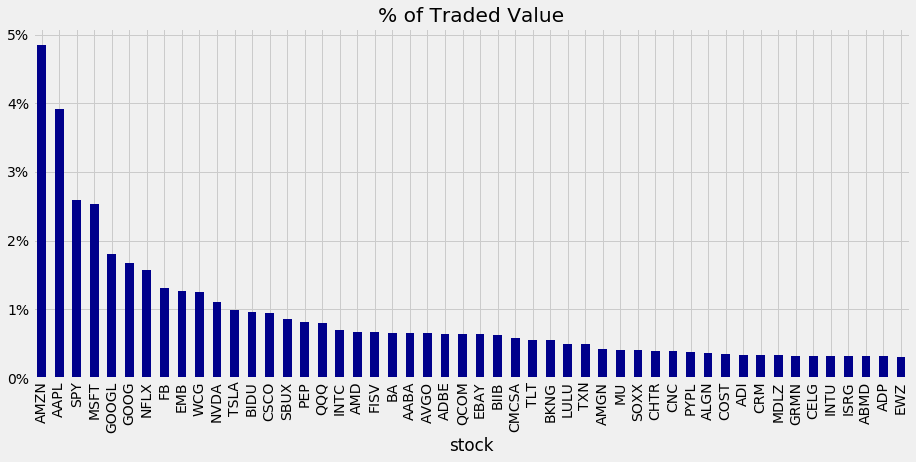

In [8]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## AAPL Trade Summary

In [9]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

In [10]:
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59233 entries, 2019-03-27 09:30:00.029662346 to 2019-03-27 15:59:59.940302031
Data columns (total 2 columns):
shares    59233 non-null int64
price     59233 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


## Tick Bars

The trade data is indexed by nanoseconds and is very noisy. The bid-ask bounce, for instance, causes the price to oscillate between the bid and ask prices when trade initiation alternates between buy and sell market orders. To improve the noise-signal ratio and improve the statistical properties, we need to resample and regularize the tick data by aggregating the trading activity.

We typically collect the open (first), low, high, and closing (last) price for the aggregated period, alongside the volume-weighted average price (VWAP), the number of shares traded, and the timestamp associated with the data.

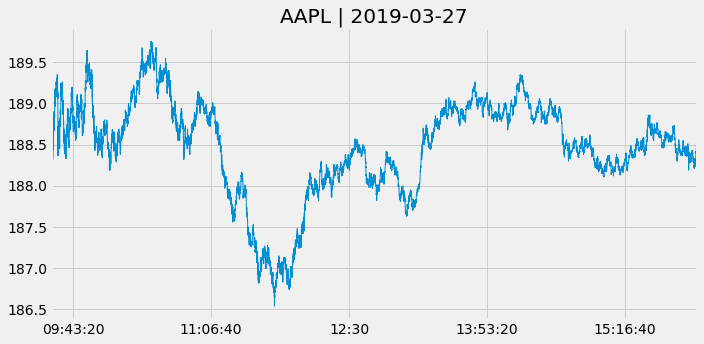

In [12]:
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(10, 5), title='{} | {}'.format(stock, pd.to_datetime(date).date()), lw=1)
plt.xlabel('')
plt.tight_layout();

### Test for Normality of tick returns

In [13]:
normaltest(tick_bars.price.pct_change().dropna())

NormaltestResult(statistic=11417.148036373566, pvalue=0.0)

## Regularizing Tick Data

### Price-Volume Chart

We will use the `price_volume` function to compare the price-volume relation for various regularization methods.

In [11]:
def price_volume(df, price='vwap', vol='vol', suptitle=title):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

### Time Bars

Time bars involve trade aggregation by period.

In [14]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)    

We create time bars using the `.resample()` method with the desired period.

In [15]:
resampled = trades.resample('1Min')
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

NormaltestResult(statistic=24.646369641916355, pvalue=4.4474270458019155e-06)

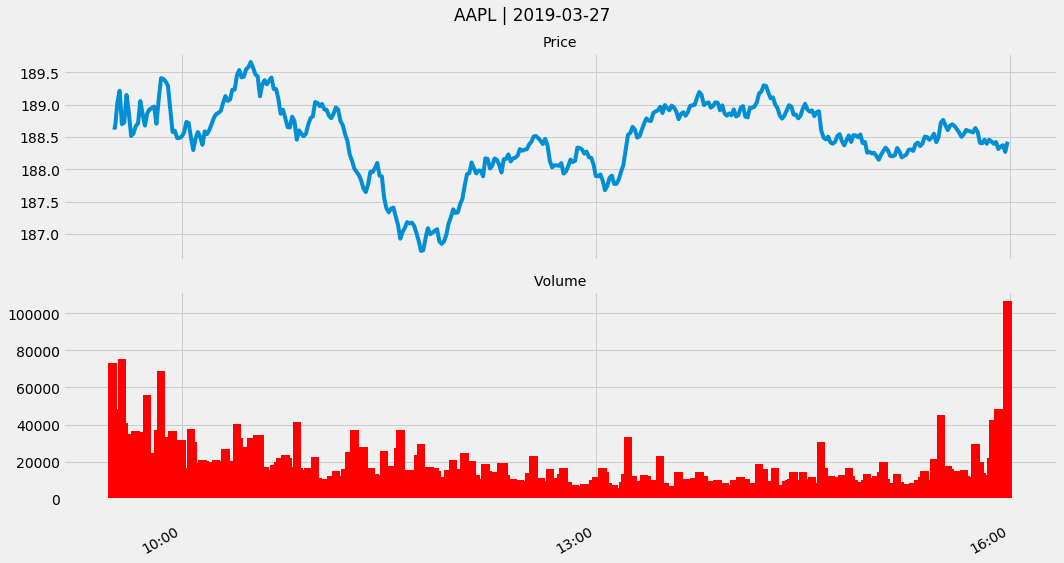

In [16]:
price_volume(time_bars)

### Bokeh Candlestick Chart

Alternative visualization using the the [bokeh](https://bokeh.pydata.org/en/latest/) library:

In [ ]:
resampled = trades.resample('5Min') # 5 Min bars for better print
df = get_bar_stats(resampled)

increase = df.close > df.open
decrease = df.open > df.close
w = 2.5 * 60 * 1000 # 2.5 min in ms

WIDGETS = "pan, wheel_zoom, box_zoom, reset, save"

p = figure(x_axis_type='datetime', tools=WIDGETS, plot_width=1500, title = "AAPL Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.4

p.segment(df.index, df.high, df.index, df.low, color="black")
p.vbar(df.index[increase], w, df.open[increase], df.close[increase], fill_color="#D5E1DD", line_color="black")
p.vbar(df.index[decrease], w, df.open[decrease], df.close[decrease], fill_color="#F2583E", line_color="black")
show(p)

![title](aapl_candlestick.png)

### Volume Bars

Time bars smooth some of the noise contained in the raw tick data but may fail to account for the fragmentation of orders. Execution-focused algorithmic trading may aim to match the volume weighted average price (VWAP) over a given period, and will divide a single order into multiple trades and place orders according to historical patterns. Time bars would treat the same order differently, even though no new information has arrived in the market.

Volume bars offer an alternative by aggregating trade data according to volume. We can accomplish this as follows:

In [18]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59233 entries, 2019-03-27 09:30:00.029662346 to 2019-03-27 15:59:59.940302031
Data columns (total 2 columns):
shares    59233 non-null int64
price     59233 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


In [19]:
trades_per_min = trades.shares.sum()/(60*7.5) # min per trading day
trades['cumul_vol'] = trades.shares.cumsum()

In [20]:
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
vol_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_vol,,,,,,,,
0,2019-03-27 09:30:00.952259968,188.75,188.75,188.60,188.67,188.69,6526,71
1,2019-03-27 09:30:06.813279061,188.60,188.78,188.57,188.58,188.70,13022,141
2,2019-03-27 09:30:12.852328216,188.58,188.58,188.30,188.37,188.42,13088,161
3,2019-03-27 09:30:30.588840948,188.33,188.89,188.32,188.82,188.77,13143,173
4,2019-03-27 09:30:45.473718520,188.82,188.83,188.46,188.56,188.66,13051,148


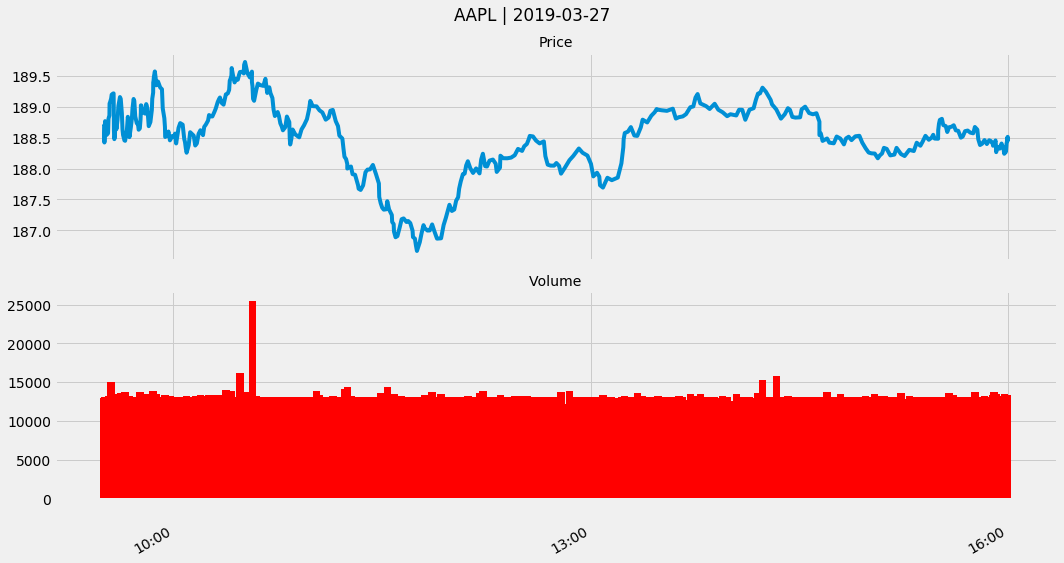

In [21]:
price_volume(vol_bars.set_index('timestamp'))

In [22]:
normaltest(vol_bars.vwap.dropna())

NormaltestResult(statistic=44.144066960487535, pvalue=2.5955993405406944e-10)